In [9]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from IPython.display import clear_output

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import random

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from keras import Sequential
from keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.callbacks import EarlyStopping, ModelCheckpoint


In [13]:
rootPath = 'dataset/Rice_Image_Dataset'
class_names = sorted(os.listdir(rootPath))[:-2]
class_names

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

In [14]:
sizes = [len(os.listdir(rootPath + '/' + name)) for name in class_names]
sizes

[15000, 15000, 15000, 15000, 15000]

In [16]:
fig = px.pie(
     names= class_names,
     values = sizes,
     width = 450 ,
     title='Class Distribution',
     hole=0.4
)
fig.update_layout({'title':{'x':0.45}})
fig.show()


In [17]:
def load_random_img(dir,label):
    plt.figure(figsize=(10,10))
    i=0
    for label in class_names:
        i+=1
        plt.subplot(1,5,i)
        file = random.choice(os.listdir(f'{dir}/{label}'))
        print(file)
        image_path = os.path.join(f'{dir}/{label}', file)
        print(image_path)

        img=cv2.imread(image_path)
        plt.title(label)
        plt.imshow(img)
        plt.grid(None)
        plt.axis('off')


Arborio (2597).jpg
dataset/Rice_Image_Dataset/Arborio/Arborio (2597).jpg
basmati (8954).jpg
dataset/Rice_Image_Dataset/Basmati/basmati (8954).jpg
Ipsala (13182).jpg
dataset/Rice_Image_Dataset/Ipsala/Ipsala (13182).jpg
Jasmine (12643).jpg
dataset/Rice_Image_Dataset/Jasmine/Jasmine (12643).jpg
Karacadag (1491).jpg
dataset/Rice_Image_Dataset/Karacadag/Karacadag (1491).jpg
Arborio (2549).jpg
dataset/Rice_Image_Dataset/Arborio/Arborio (2549).jpg
basmati (4104).jpg
dataset/Rice_Image_Dataset/Basmati/basmati (4104).jpg
Ipsala (4473).jpg
dataset/Rice_Image_Dataset/Ipsala/Ipsala (4473).jpg
Jasmine (14357).jpg
dataset/Rice_Image_Dataset/Jasmine/Jasmine (14357).jpg
Karacadag (2806).jpg
dataset/Rice_Image_Dataset/Karacadag/Karacadag (2806).jpg
Arborio (7290).jpg
dataset/Rice_Image_Dataset/Arborio/Arborio (7290).jpg
basmati (8098).jpg
dataset/Rice_Image_Dataset/Basmati/basmati (8098).jpg
Ipsala (6302).jpg
dataset/Rice_Image_Dataset/Ipsala/Ipsala (6302).jpg
Jasmine (2226).jpg
dataset/Rice_Image_Data

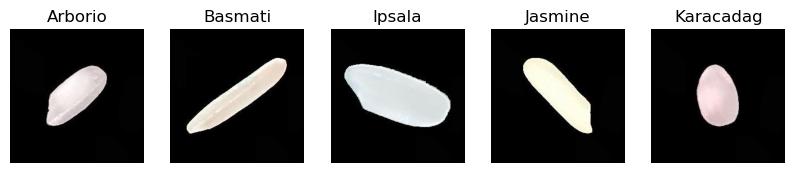

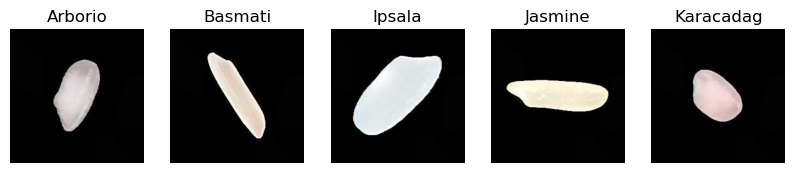

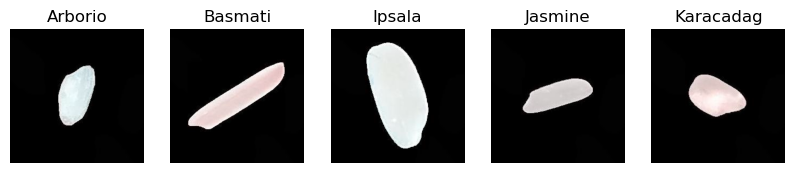

In [18]:
for i in range(3):
    load_random_img(rootPath, class_names)


In [30]:
pip install split-folders --break-system-packages

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [31]:
import splitfolders

#(Train_Val_Test)

splitfolders.ratio(rootPath, output='rice_imgs', seed=123, ratio=(.7,.15,.15), group_prefix=None)


In [32]:
batch_size = 128
img_height , img_width = 256,256
input_shape = (img_height, img_width,3)


In [33]:
# Data Pre-processing
# ImageDataGenerator can read images from disk and preprocess them into proper tensors.
# It will also set up generators that convert these images into batches of tensors—helpful when training the network.

datagen = ImageDataGenerator(rescale=1./255)

In [36]:
#After defining the generators for training and validation images, 
# the flow_from_directory method load images from the disk, applies rescaling,
# and resizes the images into the required dimensions.

Train = datagen.flow_from_directory(
            'rice_imgs/train',
            target_size = (img_height,img_width),
            batch_size = batch_size,
            subset = "training",
            class_mode='categorical')

Val = datagen.flow_from_directory(
            'rice_imgs/val',
            target_size = (img_height,img_width),
            batch_size = batch_size,
            class_mode='categorical',
            shuffle =False)

Test = datagen.flow_from_directory(
            'rice_imgs/test',
            target_size = (img_height, img_width),
            batch_size = batch_size,
            class_mode='categorical',
            shuffle=False)



Found 52500 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.


In [38]:
CNN = tf.keras.models.Sequential()

# Convolution
CNN.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu',input_shape=[256,256,3]))

#Pooling
CNN.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

#Flattening
CNN.add(tf.keras.layers.Flatten())

#Full Conection
CNN.add(tf.keras.layers.Dense(units=512,activation='relu'))

#Output layer
CNN.add(tf.keras.layers.Dense(units=5, activation='sigmoid'))



/home/kaan/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [39]:
CNN.compile(optimizer='adam', loss='binary_crossentropy' , metrics=['accuracy'])

In [41]:
Model = CNN.fit(x=Train, validation_data=Val, epochs=3)

Epoch 1/3
411/411 ━━━━━━━━━━━━━━━━━━━━ 1891s 5s/step - accuracy: 0.9407 - loss: 0.0959 - val_accuracy: 0.9724 - val_loss: 0.0373
Epoch 2/3
411/411 ━━━━━━━━━━━━━━━━━━━━ 1831s 4s/step - accuracy: 0.9894 - loss: 0.0147 - val_accuracy: 0.9898 - val_loss: 0.0131
Epoch 3/3
411/411 ━━━━━━━━━━━━━━━━━━━━ 1741s 4s/step - accuracy: 0.9945 - loss: 0.0071 - val_accuracy: 0.9828 - val_loss: 0.0262
